In [19]:
import matplotlib
import numpy as np
from numpy.random import SeedSequence
import psutil
import ray
import seaborn as sns
import time
import torch

# Set a global torch seed for reproducibility of torch RNG operations.
# Note: numpy's Generator (default_rng) is used separately and seeded where needed.
torch.manual_seed(42)

import matplotlib.pyplot as plt
import numpy.linalg as la

In [20]:
iterations = 800
num_workers = 32
it_check = 32 #
n_seeds = 5 #
max_seed = 424242 #
rng = np.random.default_rng(42)

seeds = rng.choice(max_seed, size=n_seeds, replace=False) # seeds 里的随机种子是不相同

n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-1

A = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
x_rand = rng.normal(size=dim)
b = A @ x_rand + noise_scale * rng.normal(size=n_data)# baseline


In [29]:
iterations = 800
num_workers = 32
it_check = 32 #
n_seeds = 5 #
max_seed = 424242 #
rng = np.random.default_rng(42)

seeds = rng.choice(max_seed, size=n_seeds, replace=False) # seeds 里的随机种子是不相同

n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-1

x_opt, _, _, _ = np.linalg.lstsq(A, b)


A = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
x_rand = rng.normal(size=dim)
b = A @ x_rand + noise_scale * rng.normal(size=n_data)# baseline


def evaluate(x):
    assert len(x) == dim
    return 0.5 * np.mean((A @ x - b)**2)

f_min = evaluate(x_opt)




Text(0, 0.5, '$log(F(\\mathbf{x}) - F^*)$')

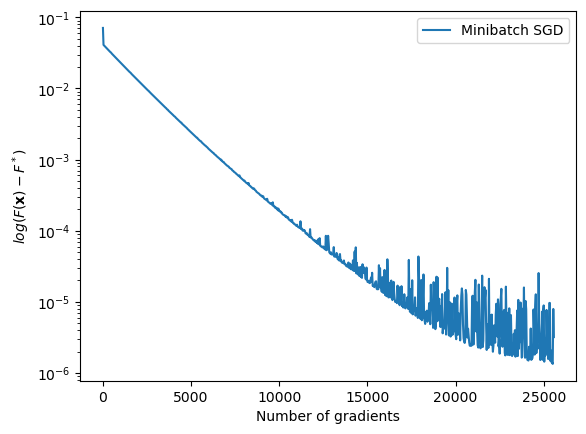

In [ ]:
def batch_grad_func(rng, x, batch_size):
    idx = rng.choice(n_data, size=batch_size, replace=False)
    return (A[idx]@x - b[idx]) @ A[idx] / batch_size

def run_single_worker_sgd(lr, iterations, batch_size, it_check):
    """
    Runs a single-worker (pure) minibatch SGD.
    """
    rng = np.random.default_rng(42)
    x = np.zeros(dim)
    
    trace = []
    its = []
    ts = []
    t0 = time.perf_counter()
    
    for it in range(iterations):
        # Calculate gradient on a large batch
        grad = batch_grad_func(rng, x, batch_size)
        
        # Update model
        x -= lr * grad
        
        if it % it_check == 0:
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)
            
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace])

x_opt, _, _, _ = np.linalg.lstsq(A, b)
f_min = evaluate(x_opt)

# Run "pure" single-worker minibatch SGD
lr_candidates = np.logspace(np.log10(0.3), np.log10(3), 10)
results = {} # 用于存储每次运行结果的字典

iterations_single = iterations * num_workers

# print("Starting grid search for single-worker SGD...")
# # 遍历所有候选学习率
# for lr in lr_candidates:
#     print(f"  Test lr = {lr:.4f}")
#     # 运行单工作节点SGD
#     its, ts, losses = run_single_worker_sgd(
#         lr=lr,
#         iterations=iterations_single,
#         it_check=it_check_single,
#         batch_size=batch_size
#     )
#     # 存储结果
#     results[lr] = (its, ts, losses)
# print("Finished grid search.")



# # 根据最终损失值找到最佳学习率
# best_lr = min(results, key=lambda lr: results[lr][2][-1])

# # 绘制结果以找到最佳学习率
# plt.figure(figsize=(10, 7))
# for lr, (its, ts, losses) in results.items():
#     # 突出显示最佳学习率的曲线
#     if lr == best_lr:
#         plt.plot(its, losses - f_min, label=f'Best lr={lr:.4f}', linewidth=2.5, zorder=len(results))
#     else:
#         # 其他曲线使用较低的透明度且不加标签
#         plt.plot(its, losses - f_min, alpha=0.3, color='gray')

# plt.yscale('log') # 使用对数尺度以便更好地观察损失下降
# plt.title('Single-Worker SGD: Learning Rate Tuning')
# plt.xlabel('Number of Gradient Evaluations')
# plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.legend()
# plt.show()

# 根据最终损失值找到最佳学习率
# min函数使用一个lambda函数作为key，该函数返回每个学习率对应的最终损失值
# best_lr = min(results, key=lambda lr: results[lr][2][-1])
# print(f"\nBest learning rate found: {best_lr:.4f}")

# # 使用最佳学习率进行最终运行并存储结果以备后续比较
# lr_single = best_lr
# # its_single, ts_single, losses_single = results[best_lr]
# # 使用最佳学习率重新运行以获得最终结果
# print(f"\nRunning single-worker SGD with the best learning rate: {best_lr:.4f}")
# its_single, ts_single, losses_single = run_single_worker_sgd(
#     lr=best_lr,
#     iterations=iterations_single,
#     it_check=it_check_single,
#     batch_size=batch_size
# )
# print("Finished final run for single-worker SGD.")

its_single, ts_single, losses_single = run_single_worker_sgd(
    lr=1.3906,
    iterations=iterations_single,
    it_check=it_check,
    batch_size=batch_size
)
plt.plot(its_single, losses_single - f_min, label='Minibatch SGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$log(F(\mathbf{x}) - F^*)$')


In [46]:
print(losses_single - f_min)

[7.09456685e-02 4.09667997e-02 4.01880510e-02 3.94314392e-02
 3.86631683e-02 3.79656288e-02 3.72246195e-02 3.65005799e-02
 3.58420564e-02 3.51516324e-02 3.45014828e-02 3.37997479e-02
 3.32112321e-02 3.25346780e-02 3.21238378e-02 3.13353574e-02
 3.07113576e-02 3.01539055e-02 2.95582869e-02 2.90592191e-02
 2.84656658e-02 2.79261771e-02 2.73938149e-02 2.68864434e-02
 2.63971902e-02 2.59106746e-02 2.54262117e-02 2.49143991e-02
 2.45813585e-02 2.40661308e-02 2.35632704e-02 2.31308468e-02
 2.26908507e-02 2.22516213e-02 2.19586022e-02 2.14981388e-02
 2.10420655e-02 2.06350254e-02 2.02753391e-02 1.98745575e-02
 1.95133640e-02 1.91703023e-02 1.87960668e-02 1.84565230e-02
 1.80928403e-02 1.77826101e-02 1.74494238e-02 1.71226572e-02
 1.68577899e-02 1.66039373e-02 1.62069037e-02 1.59068326e-02
 1.56188585e-02 1.53346901e-02 1.50968779e-02 1.48257716e-02
 1.45162446e-02 1.42322760e-02 1.39957489e-02 1.37304062e-02
 1.35249415e-02 1.32465974e-02 1.29821744e-02 1.27456505e-02
 1.25228203e-02 1.229806

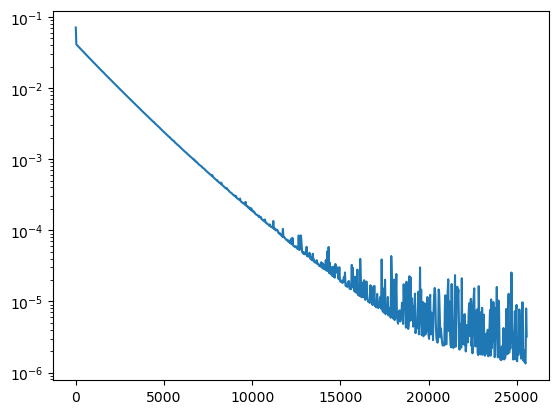

In [41]:
def run_single_worker_sgd2(lr, iterations, batch_size):
    """
    Runs a single-worker (pure) minibatch SGD.
    """
    rng = np.random.default_rng(42)
    x = np.zeros(dim)
    
    trace = []
    its = []
    ts = []
    t0 = time.perf_counter()

    for it in range(iterations):
        # Calculate gradient on a large batch
        grad = batch_grad_func(rng, x, batch_size)
        
        # Update model
        x -= lr * grad
        
        if it % it_check == 0:
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)
            
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace])

lr = 0.43
num_workers_single = 32
iterations_single = iterations * num_workers_single
its_single2, ts_single2, losses_single2 = run_single_worker_sgd2(
    lr=1.3925,
    iterations=iterations_single,
    batch_size=batch_size
    # it_check=it_check_single
)

x_opt, _, _, _ = np.linalg.lstsq(A, b)
f_min = evaluate(x_opt)
plt.yscale('log')
plt.plot(its_single2, losses_single2- f_min, label='Single-worker SGD')

In [42]:
print(losses_single2- f_min == losses_single- f_min)

ValueError: operands could not be broadcast together with shapes (800,) (25,) 